- 姓名：林芷翎
- 學號：711133123
- 作品目標：本研究以紅酒資料集為探討對象，使用三種不同的分類器對原始資料及經主成分分析後的資料進行分類。研究中針對不同的參數設計進行探討，並進一步探討參數如何影響分類結果。

讀取相關套件

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import  classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier

讀取與切割資料
- 紅酒資料集，包含13項成分變數(Alcohol、Malic_Acid...等)與1項類別變數（Customer_Segment）
- 將資料的70%作為訓練資料，30%分為測試集資料

In [26]:
df = pd.read_excel('data/wine.xlsx')
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

#### 一、多元羅吉斯回歸（Multiple logistic regression analysis）
    學習器(solver):用於解決最小化損失函數的優化問題，以找到最佳的模型參數。
- L-BFGS：利用先前的梯度估計來近似成本函數的海森矩陣，尤其適用於小型和中型數據集。
- LIBLINEAR：基於坐標軸下降的求解器，對於大型數據集效果比較好，尤其是在 L1 正則化（Lasso）。
- Newton-CG：通過海森矩陣來進行優化，這種求解器對於大型數據集效果比較好，尤其是在 L2 正則化（Ridge）。

    評估指標
- 精確率（Precision）:分類器預測為正樣本的樣本中，真正為正樣本的比例，TP (TurePositive)、FP (FalsePositive)。    

  計算公式：$\frac{TP}{TP+FP}$     

- 召回率（Recall）：表示正樣本中被分類器預測為正樣本的比例，TP (TurePositive)、FN (FalseNegative)。  

  計算公式：$\frac{TP}{TP+FN}$  

- 調和平均值（F1-score）：綜合考慮精確率和召回率的指標。  

  計算公式：$2*\frac{Precision * Recall}{Precision + Recall}$。  

- 樣本數（Support）：測試集中每個類別的樣本數。在計算precision、recall和F1-score時，每個類別的support都是相同的。

1. 原始資料使用 LogisticRegression 進行分類任務，不同學習器（solver）的分類結果
- 學習器『lbfgs』：準確率為 96.3%
- 學習器『liblinear』：準確率為 94.44%
- 學習器『newton-cg』：準確率為 96.3%

In [86]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0) # verbose = 0不輸出迭代過程
solver = ['lbfgs', 'liblinear', 'newton-cg'] 
acc_original = []
for x in solver:
    clf_original = LogisticRegression(solver = x, **opts)
    clf_original.fit(X_train, y_train)
    y_pred = clf_original.predict(X_test)
    # print(classification_report(y_test, y_pred))
    accuracy = clf_original.fit(X_train, y_train).score(X_test, y_test)
    print(f"Accuracy : {accuracy:.2%}\n")
    acc_original.append(accuracy)

Accuracy : 96.30%

Accuracy : 94.44%

Accuracy : 96.30%



2. 將標準化後的資料進行主成分分析（PCA）降維，並使用 LogisticRegression 進行分類任務，不同學習器（solver）與主成分個數的分類結果

In [88]:
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)


q = [1, 2, 3]
results = {}
for n in q:
    pca = PCA(n_components=n).fit(X_train_)
    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)
    solver_results = {}
    for x in solver:
        clf_PCA = LogisticRegression(solver=x, **opts)
        accuracy = clf_PCA.fit(Z_train, y_train).score(Z_test, y_test)
        solver_results[x] = accuracy
    results[f"PCA(q={n})"] = solver_results

df = pd.DataFrame(results)
df['Rowdata'] = acc_original
df.applymap(lambda x: '{:.2%}'.format(x))



,PCA(q=1),PCA(q=2),PCA(q=3),Rowdata
lbfgs,70.37%,92.59%,96.30%,96.30%
liblinear,74.07%,94.44%,98.15%,94.44%
newton-cg,70.37%,92.59%,96.30%,96.30%


&rarr; 將資料進行主成分分析後，不同的學習器產生不同的分類準確率，選取2個主成分就有與原始資料相近的準確率，因此在做資料分析時，可以選擇2個主成分來加快分析速度。同時，這個結果與抽樣選取的樣本有關，因此沒有絕對的關係。

原始資料與主成分分析後資料散佈圖  

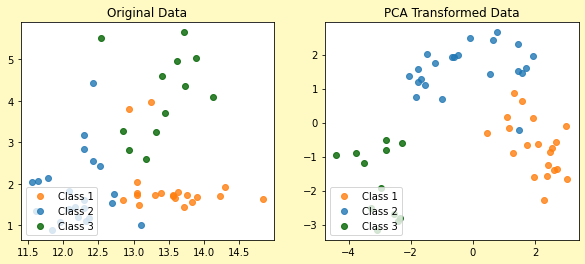

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), facecolor='#FFF9C4')
colors = ['tab:orange', 'tab:blue', 'darkgreen']
for i in range(3):
    ax[0].scatter(X_test[y_test == i+1, 0], X_test[y_test == i+1, 1], color = colors[i], alpha = 0.8, label = f'Class {i+1}')
ax[0].set_title('Original Data')
ax[0].legend(loc='lower left')

for i in range(3):
    ax[1].scatter(Z_test[y_test == i+1, 0], Z_test[y_test == i+1, 1], color = colors[i], alpha = 0.8, label = f'Class {i+1}')
ax[1].set_title('PCA Transformed Data')
ax[1].legend(loc='lower left')

plt.show()

&rarr; 由圖可見，只選取2個主成份的情況下，主成分分析後的資料與原始資料都方便進行分類任務。將資料選取兩個主成分，不但能減少冗餘的信息並保留關鍵的特徵，也能減少模型的運算時間。

#### 二、支援向量機（Support Vector Machine）
SVM (Support Vector Machine) 是一種監督式學習方法，常用於二分類或多分類問題。
- 目的 : 在特徵空間中找到一個最優的超平面（decision boundary），將不同類別的樣本分離開來，使得兩類樣本之間的邊際最大化。
- 方法 : 可以處理非線性問題，通過映射特徵空間到更高維度的空間中，把原本線性不可分的問題轉化為線性可分的問題，進而用線性方法求解。
- 優點 : 處理高維數據時表現優異，且在訓練過程中避免了局部最優解問題。
- 缺點 : 對於大規模數據訓練速度較慢，且對於噪聲較多的數據容易受到干擾，且對於核函數的選擇和參數的調整也需要一定的專業知識和經驗。

    正則化參數（C）: 防止模型過擬合訓練集的一種方法，它會對模型中的參數進行懲罰，使得模型不會過度依賴任何一個特徵。
- 較大的C值會導致更嚴格的邊界和更少的分類錯誤，但也會使模型過度擬合訓練數據。
- 較小的C值會導致邊界變得更寬鬆，但也可能導致模型的泛化能力不足。
- 可以通過交叉驗證等技術來選擇最適合的C值，適當的C值在模型的準確性和泛化能力之間取得平衡。


    核函數（Kernel）： 用來將資料映射到高維空間的一種技巧，使得資料在高維空間中更容易被線性分類器分割。
- 線性核函數（Linear kernel）：最簡單的核函數之一，將資料映射到原始資料維度的空間，這樣可以將資料在高維空間中線性分割。
- 徑向基核函數（Radial Basis Function, RBF）：最常用的核函數之一。將資料映射到無限維空間，調整超參數gamma和C來控制模型的複雜度和性能。
- 多項式核函數（Polynomial kernel）：將資料映射到更高維度的空間，通過調整超參數degree來控制映射的次數，使得模型更適合資料。

    分類方式（decision_function_shape）
- one vs one (ovo)：每兩個類別之間建立一個二元分類器。
- one vs the rest (ovr)：建立 k 個二元分類器，每個二元分類器負責將其中一個類別和其它類別做二元分類。

1. 原始資料使用下列參數使用支援向量機（SVM）進行分類任務
- 正規劃參數：c = 1
- 分類方式：one vs one (ovo)
- 核函數：多項式核函數（poly）  

&rarr; 對於原始資料，使用正規化參數c = 1和多項式核函數(poly)進行分類，取得了94%的準確率。

In [15]:
C = 1 
opts = dict(C = C, decision_function_shape = 'ovo',tol = 1e-6, max_iter = int(1e6))
clf_svm = SVC(kernel = "poly", degree=3, gamma = "auto", **opts) 
clf_svm.fit(X_train, y_train)
predictions = clf_svm.predict(X_test) 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.95      1.00      0.98        20
           2       1.00      0.86      0.93        22
           3       0.86      1.00      0.92        12

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



2. 將標準化後的資料（Z_train、Z_est）進行主成分分析（PCA）降維至2維，並使用 SVC 與 LinearSVC 進行分類任務。   
- SVC 可以處理線性和非線性分類、回歸以及異常檢測等問題，其核函數包括線性核函數、多項式核函數、高斯核函數等。 
- LinearSVC 只能處理線性分類問題，使用的是線性核函數，並且可以通過L1或L2正則化控制模型的複雜度，從而避免過擬合的問題。

&rarr; 當資料轉為二維後，使用 SVC（77.78%）比使用 LinearSVC（74.07%）進行分類的準確率高，當資料為二維時，使用SVC（kernel = "linear"）是一個好的選擇。

In [22]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0)
clf_svm = SVC(kernel = "linear", degree = 3, gamma = "auto", **opts) 
clf_svm.fit(Z_train, y_train)
predictions = clf_svm.predict(Z_test) 
print(f"SVM : {clf_svm.score(Z_test, y_test):.2%}\n")

clf_svm = LinearSVC(**opts) 
clf_svm.fit(Z_train, y_train)
predictions = clf_svm.predict(Z_test) 
print(f"LinearSVM : {clf_svm.score(Z_test, y_test):.2%}\n")

SVM : 77.78%

LinearSVM : 74.07%



#### 三、神經網路（Neural network）
    多層分類器（MLPClassifier） : 是一種多層感知器（Multilayer Perceptron，MLP）模型
- 具有多個隱藏層，每個隱藏層包含多個神經元，每個神經元都與上一層和下一層的神經元相連接。
- 可以用於處理複雜的非線性問題
- 使用反向傳播算法（backpropagation）進行訓練，通過調整權重和偏差，將輸入的特徵映射到輸出類別。
- 支持不同的激活函數、正則化和學習率等超參數的設置。

    學習器（solver）
- adam：使用自適應矩估計（Adam）算法進行權重更新
- sgd：使用隨機梯度下降算法進行權重更新
- lbfgs：使用似牛顿方法的有限記憶BFGS算法進行權重更新  

&rarr; 不同的學習器算法可能在訓練時間、準確性和可靠性等方面產生不同的效果。

    激活函數（activation）
- identity：將輸入直接傳遞到輸出，通常用於迴歸問題
- logistic：也稱為 sigmoid 函數，將輸入映射到範圍為 (0, 1) 的輸出，通常用於二元分類問題
- tanh：將輸入映射到範圍為 (-1, 1) 的輸出，通常用於多類別分類問題
- relu：也稱為整流線性單元，將輸入映射到非負的輸出，通常用於分類問題和迴歸問題

1. 原始資料使用神經網路模型進行分類任務，選擇不同的學習器與激活函數計算準確率。

In [106]:
hidden_layers = (30,)
activation = ['identity','logistic','tanh','relu']
solver = ['adam','sgd','lbfgs']

opts = dict(hidden_layer_sizes = hidden_layers, verbose = False, tol = 1e-6, max_iter = int(1e6))

for a in activation:
    for x in solver:
        clf_MLP = MLPClassifier(solver = x, activation = a, **opts) 
        print(f"Accuracy ({a,x}): {clf_MLP.fit(X_train, y_train).score(X_test, y_test):.2%}\n")



Accuracy (('identity', 'adam')): 29.63%

Accuracy (('identity', 'sgd')): 37.04%

Accuracy (('identity', 'lbfgs')): 94.44%

Accuracy (('logistic', 'adam')): 94.44%

Accuracy (('logistic', 'sgd')): 40.74%

Accuracy (('logistic', 'lbfgs')): 40.74%

Accuracy (('tanh', 'adam')): 94.44%

Accuracy (('tanh', 'sgd')): 40.74%

Accuracy (('tanh', 'lbfgs')): 70.37%

Accuracy (('relu', 'adam')): 94.44%

Accuracy (('relu', 'sgd')): 37.04%

Accuracy (('relu', 'lbfgs')): 40.74%



/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


原始資料使用下列參數使用神經網路（Neural network）訓練模型，觀察損失曲線（LossCurve）
- 隱藏層神經元個數：hidden_layers = (30,)
- 激活函數：activation = 'logistic'
- 學習器：solver = 'adam' 

&rarr; 原始資料使用神經網路模型進行分類任務，模型的隱藏層有30個神經元，激活函數使用logistic，學習器採用『adam』，得到準確率為 94.44%。

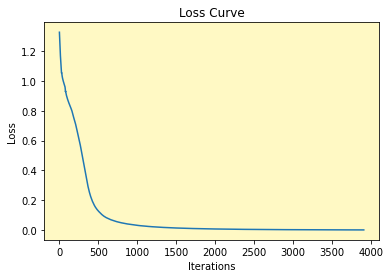

In [103]:
clf_MLP = MLPClassifier(solver = 'adam', **opts) 
clf_MLP.fit(X_train, y_train)
plt.gca().set_facecolor('#FFF9C4')
plt.plot(clf_MLP.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

2. 將標準化後的資料進行主成分分析（PCA）降維，並使用MLPClassifier進行分類任務，繪圖觀察分析結果。
- 左圖為不同主成份個數下使用MLPClassifier進行分類任務的準確率，此圖的結果顯示當主成分個數選擇2時就有很高的分類準確率。
- 右圖為MLPClassifier每一個epoch訓練過程中的損失(loss)值，每個元素對應到一個epoch。此圖用來檢視訓練過程中的損失變化情形，判斷訓練是否過度擬合(overfitting)等問題。

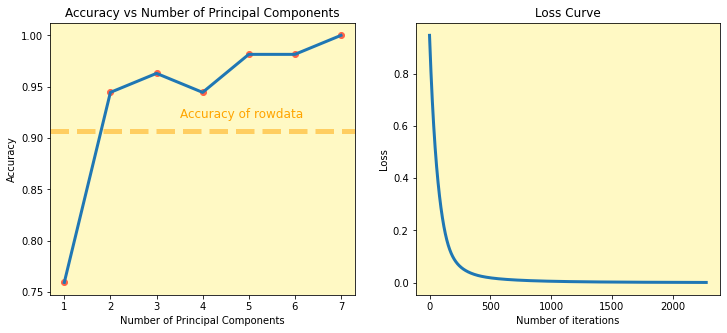

1.0


In [116]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
n_components_list = [1, 2, 3, 4, 5, 6, 7]

scores = []
for n in n_components_list:
    pca = PCA(n_components = n).fit(X_train_)
    Z_train = pca.transform(X_train_)
    Z_test = pca.transform(X_test_)
    clf_MLP_PCA = MLPClassifier(solver = 'adam', **opts)
    score = clf_MLP_PCA.fit(Z_train, y_train).score(Z_test, y_test)
    scores.append(score)
for i, score in enumerate(scores):
    ax1.scatter(n_components_list[i], score, color='tomato', edgecolors='tomato')
ax1.axhline(y = 0.907, color = 'orange', alpha = 0.5, ls = '--', lw = 5)
ax1.text(3.5, 0.92, "Accuracy of rowdata", fontsize = 12, color = 'orange')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Number of Principal Components')
ax1.plot(n_components_list, scores, lw = 3)
ax1.set_facecolor("#FFF9C4")
ax2.plot(clf_MLP_PCA.loss_curve_, lw = 3)
ax2.set_xlabel('Number of iterations')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Curve')
ax2.set_facecolor("#FFF9C4")
plt.show()


In [117]:
scores

[0.7592592592592593,
 0.9444444444444444,
 0.9629629629629629,
 0.9444444444444444,
 0.9814814814814815,
 0.9814814814814815,
 1.0]

    結論：
- 在多元羅吉斯迴歸中，主成分個數為2，學習器為『lbfgs』與『newton-cg』皆有相同的分類準確率準確率為 96.3%。
- 在支援向量機中，對於原始資料，使用正規化參數c = 1和多項式核函數(poly)進行分類，取得了94%的準確率。進行主成分分析後，選取主成分個數2，使用 SVC（77.78%）比使用 LinearSVC（74.07%）進行分類的準確率高。
- 在神經網路中，原始資料的最高準確率為94.44％。在進行主成分分析後，主成分選取2個就有很高的準確率（94.44%），選取到7個主成分時準確率到達100%。

&rarr; 總體而言，針對這個資料集，使用神經網路演算法得到的分類準確率最好。然而，由於樣本抽樣的影響，這個結果只能呈現相對的準確率比較，想進一步比較不同演算法之間的差異，可以使用重複抽樣再取平均值的方式來探討分類結果。